Santeri Hynninen

CASE: F1 EMILIA-ROMAGNAN GP 2024
GOAL: Predict the top 5 drivers for the race

APPROACH

First thoughts: The tracks, cars and drivers are different are changing every time: not that much datapoints
                The track characteristics could have big impact of how well the car and the driver performs
                We should compare the drivers performance to the track characterictics

DATA Sources:    GeoJson data from the most of the tracks: https://github.com/bacinger/f1-circuits/tree/master/circuits
                 Race statistics from: https://github.com/f1db/f1db/

                Final dataframe should be something like
                Year, Driver, Team, Weather(maybe), n x (different track attributes), placement

RESTRICTIONS:   There have been large changes to the cars in season 2022, thus we will use data only from seasons 2022-2024
                Tiremanufacturer is Pirel for every driver

TRACK ATTRIBUTES:       We would like to have the charestics of track - what are these charestics?
                        Note that we dont have to project the geodata because we are looking relative attributes of the data
                        Straights: 
                        Curves:  [over40, over30, over15, avg, stdev, avg_diff, stdev_diff]

HOW SPECIAL CASES ARE HANDELED:
                        Categorial data(engine manufacturer and driver) are one hot encoded: https://en.wikipedia.org/wiki/One-hot
                        (each category value is changed to truth column)

                        NAs(only in position column when the driver did not finish)
                        These values are removed because the prediction is impossible
                

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [37]:
FROM_YEAR = 2020

track_type = {'ROAD':0,
              'STREET':1,
              'RACE':2}

In [38]:
df = pd.read_csv(r'data\f1db-races-race-results.csv')
df = df[['raceId','year','positionNumber', 'driverId',"gapMillis", "driverNumber"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
df = df[~df['positionNumber'].isna()]
race_results = df

df = pd.read_csv(r'data\f1db-races-qualifying-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying1= df

df = pd.read_csv(r'data\f1db-races-qualifying-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying2= df

df = pd.read_csv(r'data\f1db-races-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying3= df


df = pd.read_csv(r'data\f1db-races-free-practice-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice1= df

df = pd.read_csv(r'data\f1db-races-free-practice-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice2= df

df = pd.read_csv(r'data\f1db-races-free-practice-3-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice3= df

df = pd.read_csv(r'data\f1db-races-free-practice-4-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice4= df

df = pd.read_csv(r'data\f1db-races-sprint-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint_q= df

df = pd.read_csv(r'data\f1db-races-sprint-race-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint= df

df = pd.read_csv(r'data\f1db-races-pit-stops.csv')
df = df[["raceId","driverId","stop","timeMillis"]]
pit_stops= df

df = pd.read_csv(r'data\f1db-races.csv')
df = df[['id','courseLength', "circuitType"]]
df['circuitType'] = df['circuitType'].apply(lambda x: track_type[x])
race_tracks = df




In [39]:
df = pit_stops.groupby(["raceId","driverId"],as_index=False).mean()
pit_stops = df

df = race_result

In [40]:

df = pd.merge(race_results, race_practice1, how='left', on=['raceId','driverId'], suffixes=(None, '_practice1'))
df = pd.merge(df, race_practice2, how='left', on=['raceId','driverId'], suffixes=(None, '_practice2'))
df = pd.merge(df, race_practice3, how='left', on=['raceId','driverId'], suffixes=(None, '_practice3'))
df = pd.merge(df, race_qualifying3, how='left', on=['raceId','driverId'], suffixes=('_race', '_qualifying3'))
df = pd.merge(df, race_tracks, how='left', left_on=['raceId'], right_on=['id'],suffixes=(None, '_track'))
df = pd.merge(df, race_sprint_q, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint_q'))
df = pd.merge(df, race_sprint, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint'))
df = pd.merge(df, pit_stops, how='left', on=['raceId','driverId'],suffixes=(None, '_pitstops'))

df =df[df['year'] >=FROM_YEAR]
df = df.drop('id', axis=1)

df.sort_values(by=['positionNumber_race', 'positionNumber_practice1', 'positionNumber_practice2', 'positionNumber_practice3', 'positionNumber_qualifying3'], axis=0, inplace=True)
df = df.ffill(axis=1)

print(df.isna().sum())
df['positionNumber_race'] =df['positionNumber_race'].apply(lambda x: int(x))
#df['driverId'] =df['driverId'].apply(lambda x: driver_id.index(x))

position_columns = ['positionNumber_race', 'positionNumber_practice1', 'positionNumber_practice2', 
                    'positionNumber_practice3', 'positionNumber_qualifying3',
                    'positionNumber', 'positionNumber_sprint']

df = df[~(df[position_columns] > 30).any(axis=1)]
df['top5'] = df['positionNumber_race'] < 6
df['top5'] = df['top5'].astype(int)
historic_performance = df.drop(['raceId', 'driverId', 'year'], axis=1)

historic_performance

raceId                        0
year                          0
positionNumber_race           0
driverId                      0
gapMillis_race                0
driverNumber                  0
positionNumber_practice1      0
gapMillis_practice1           0
positionNumber_practice2      0
gapMillis_practice2           0
positionNumber_practice3      0
gapMillis_practice3           0
positionNumber_qualifying3    0
gapMillis_qualifying3         0
courseLength                  0
circuitType                   0
positionNumber                0
positionNumber_sprint         0
stop                          0
timeMillis                    0
dtype: int64


,positionNumber_race,gapMillis_race,driverNumber,positionNumber_practice1,gapMillis_practice1,positionNumber_practice2,gapMillis_practice2,positionNumber_practice3,gapMillis_practice3,positionNumber_qualifying3,gapMillis_qualifying3,courseLength,circuitType,positionNumber,positionNumber_sprint,stop,timeMillis,top5
15300,1,0.0,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,4.675,2,2,2,1.5,22299.0,1
15463,1,0.0,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.807,2,2,2,1.5,24039.0,1
15510,1,0.0,1,1.0,0.0,1.0,0.0,1.0,0.0,3.0,97.0,4.304,2,2,2,2.0,417978.333333,1
14371,1,0.0,44,1.0,0.0,1.0,0.0,2.0,263.0,1.0,0.0,5.412,2,2,2,2.0,404128.333333,1
14554,1,0.0,33,1.0,0.0,1.0,0.0,2.0,204.0,1.0,0.0,4.318,2,2,2,1.0,20936.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14553,20,0.0,9,18.0,3203.0,20.0,2679.0,20.0,3342.0,18.0,0.0,5.842,2,2,2,1.0,30983.0,0
15579,20,0.0,20,19.0,1390.0,17.0,1604.0,19.0,1234.0,17.0,0.0,5.281,2,2,2,1.5,22463.5,0
15280,20,0.0,2,19.0,2494.0,20.0,2108.0,17.0,1729.0,20.0,0.0,5.41,1,1,1,1.0,48938.0,0
15319,20,0.0,2,19.0,1900.0,20.0,1508.0,20.0,2865.0,20.0,0.0,4.675,2,2,2,1.5,23205.0,0


In [41]:
#sns.pairplot(historic_performance)
#plt.show()

In [42]:
#Training and test sets
sc = MinMaxScaler()
df = historic_performance
x1, y1 = df.drop(['positionNumber_race', 'top5'], axis=1), df['positionNumber_race']
x2, y2 = df.drop(['positionNumber_race', 'top5'], axis=1), df['top5']

x1 = pd.DataFrame(sc.fit_transform(x1), columns=x1.columns)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, train_size=0.8)
x_train.head().T



,434,772,550,203,865
gapMillis_race,0.000000,0.060203,0.172770,0.299388,0.304990
driverNumber,0.551020,0.775510,0.306122,0.632653,0.469388
positionNumber_practice1,0.076923,0.653846,0.423077,0.346154,0.384615
gapMillis_practice1,0.005970,0.096282,0.075714,0.067794,0.100952
positionNumber_practice2,0.074074,0.444444,0.407407,0.296296,0.481481
gapMillis_practice2,0.022133,0.204800,0.216298,0.069704,0.180943
positionNumber_practice3,0.592593,0.555556,0.296296,0.222222,0.333333
gapMillis_practice3,0.080577,0.043262,0.021005,0.021353,0.032203
positionNumber_qualifying3,0.300000,0.950000,0.600000,0.600000,0.400000
gapMillis_qualifying3,0.029486,0.000000,0.000000,0.000000,0.049747


In [43]:
def visualize(y_test, y_pred, label):
    score_df = pd.DataFrame({'test': y_test, 'pred': y_pred, 'diff':y_test-y_pred})
    agg_df = score_df.groupby(['test', 'pred']).size().reset_index(name='count')
    sns.scatterplot(x='test', y='pred', size='count', data=agg_df)
    x_values = np.linspace(agg_df['test'].min(), agg_df['test'].max(), 10)
    plt.plot(x_values, x_values, color='red', linestyle='-')
    plt.title(label)
    plt.show()
   

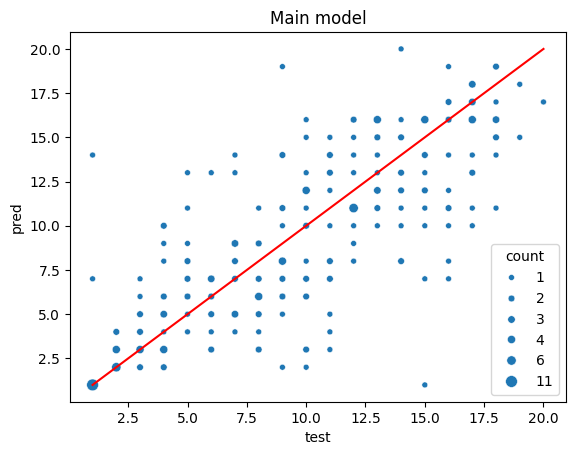

Accuracy of ensembled model: 0.1440329218106996
Cross-Val score: 0.22222222222222224


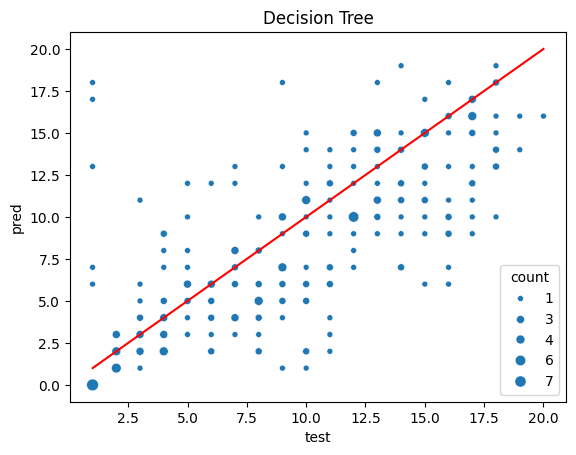

Decision Tree 0.1522633744855967


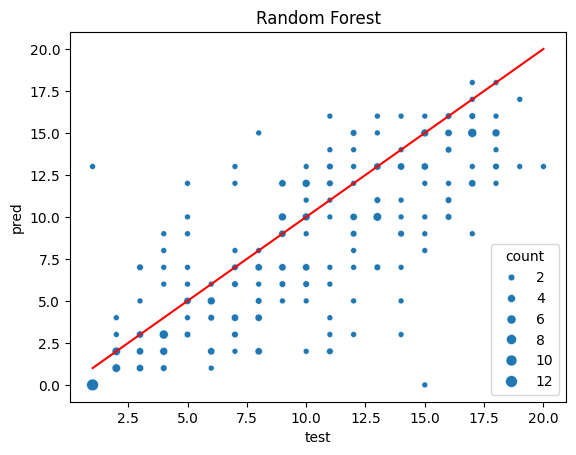

Random Forest 0.14814814814814814


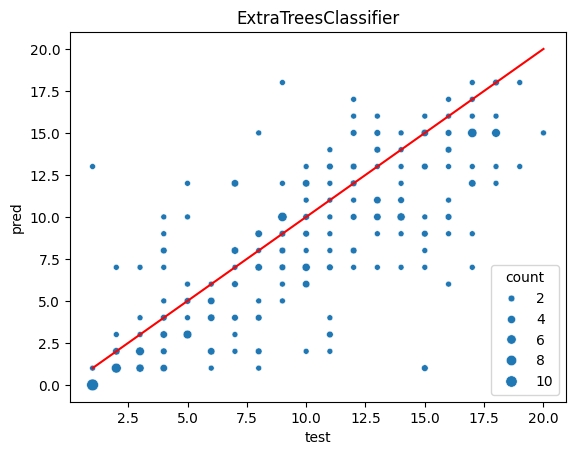

ExtraTreesClassifier 0.11522633744855967


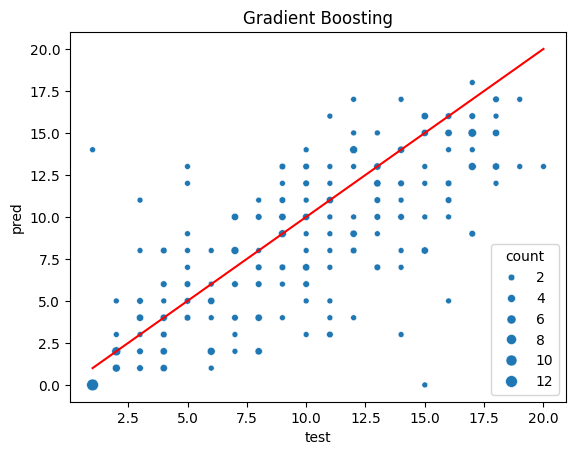

Gradient Boosting 0.1440329218106996


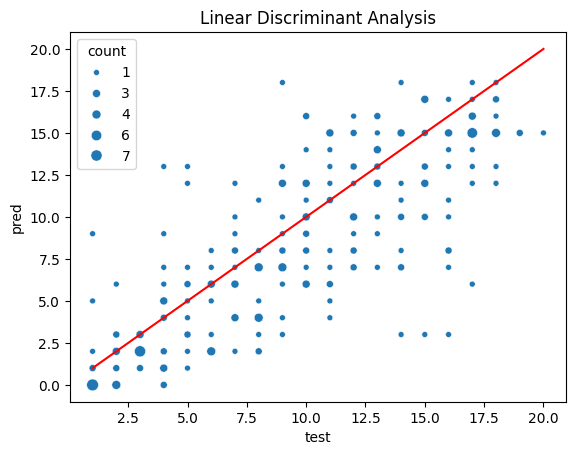

Linear Discriminant Analysis 0.11934156378600823


In [45]:
classifiers = [
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(max_features=5)),
    ("ExtraTreesClassifier", ExtraTreesClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis())
]
    
models = VotingClassifier(estimators=classifiers, voting='soft')
models.fit(x_train, y_train)
y_pred = models.predict(x_test)
visualize(y_test, y_pred, label='Main model')
print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
print("Cross-Val score:", cross_val_score(models, x, y, cv=5).mean())
scores = {}
for name, model in models.named_estimators_.items():
        y_pred = model.predict(x_test)
        scores[name] = accuracy_score(y_test, y_pred)
        visualize(y_test, y_pred, label=name)
        print(name, accuracy_score(y_test, y_pred))

